## Question: Is this patient potentially in need of treatment for Gout?
### Project predicts patient's diagnosis of 'Gout' based on only their Chief Complaint.

**Contents**
* Data
    * Source Description
    * Data import
    * Split for training and testing
    * Vector training data to weighted, normalized, float integers
    * Encode Test data
* Models
    * Instantiate list of models
* Methods
     * fit
     * ROC AUC
     * Confusion Matrix
     * Scores
* Build
     * Run methods:  fit and visualize models
     * Tune Hyperparameters
     * Build and run tuned models
* Results
     * Display summary of scores
     * Display bar plot of scores
     * Change after tuning

## Data

###  Source Description
The data is found in the MIMIC-III (Medical Information Mart for Intensive Care III) database.  Details can be found at https://physionet.org/content/emer-complaint-gout/1.0/.   Acces to the database may be requested at (https://mimic.physionet.org/gettingstarted/access/).  The data is contained in 2 csv files from years 2019 and 2020.

###  Data Import:  Cleaned in notebook "Capstone_2_Cleaning&EDA"

In [1]:
import pandas as pd
df = pd.read_pickle("noGoutTerm.csv")
wdf = pd.read_pickle("withGoutTerm.csv")
df.shape

(8275, 2)

### Split data for training and testing: stratify due to imbalanced data, set random_state seed for reproducability

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
    
    # split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    df['corpus'],                                     
    df.target,                                       
    test_size=0.30,                                   
    stratify=df.target,                                # Stratify the imbalanced target
    random_state=1,                                    # Constant seed for reproducibility
    shuffle=True                                       # Set for the 'statify' parameter
)

###  Vector training data:  converts to normalized, weighted float int

In [3]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

    # Vectoring the corpus from string to int, the TFidf method will weight the keywords
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

### Encode test data:  for use in ROC AUC plot

In [4]:
labelencoder=LabelEncoder()                     # Simple direct encoding from string to int
E_y_test = labelencoder.fit_transform(y_test)

##  Models

### Instantiate Models with default hyperparamters ( empty param_grid) and seed the random_state when possible for reproducability and comparison to tuned models

In [5]:
# Import Models form sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
# List of dictionaries cotaining models with their label and hyperparameters (default for untuned models)
models_untuned = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(random_state=1),     # see the random state for reproducabity during tuning
    'grid' : {}                                      # default hyperparameters
},  
{   'label' : 'Naive Bayes',
    'model' : MultinomialNB(),
    'grid' : {}
},  
{   'label' : 'SVM',
    'model' : svm.SVC(random_state=1),
    'grid' : {}
},
    {   'label' : 'KNNeighbors',     
    'model' : KNeighborsClassifier(),
    'grid' : {}
},   
{   'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(random_state=1),
    'grid' : {}
}, 
{   'label' : 'Random Forest',   
     'model' : RandomForestClassifier(random_state=1),
    'grid' : {}
}
]

## Methods
   
* Fit Models
* Plot ROC AUC
* Plot Confusion Matrices
* Display Scores

In [7]:
# Load Libraries necessary for the mothods that follow

from sklearn import metrics
import matplotlib.pyplot as plt
import imblearn
from imblearn.pipeline import make_pipeline, Pipeline
from numpy import mean
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

### "fit_models"
* fits a list of models using a combination upsample/downsample method wrapped inside a crossvalidation method
* takes list of dictionaries containing model label(str), classifier (estimator), parameter grid (dict)
* Returns: 
    * dictionary of each models prediction
    * dataframe summarizing scores
    * list of best parameters
    * list of fitted models

In [8]:
import warnings
warnings.filterwarnings('ignore')

def fit_models(models):
    
    predictions = {}                                # Variables
    all_models = []
    best_params = []
    ROCscores = pd.DataFrame(columns = {'model', 'score'})
    i = 0
    
    for m in models:                                # Extract objects from dictionary
        model = m['model']  
        param_grid = m['grid']
        label = m['label']
                                                                               # Balance the data
        over = RandomOverSampler(sampling_strategy=0.1, random_state=1)
        under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
        steps = [('o', over), ('u', under), ('m', model)]
        pipeline = Pipeline(steps=steps)                                       # Pipe the data into a gridsearchCV
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # Split the data 10 times
        grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv)    # Prevent overfitting
        grid_fit = grid.fit(X_train, y_train)                                  # Fit Model
        
        best_params.append(grid_fit.best_params_)    # store the parameters and fitted models
        all_models.append(grid_fit)

        if label == 'SVM':                           # Get predictions on each model
            prediction = grid_fit.decision_function(X_test)  # Specific to SVM model 'decision function'
        else:                         
            prediction = grid_fit.predict_proba(X_test)[:,1]
            
        predictions[label] = prediction    
        score = metrics.roc_auc_score(y_test, prediction)
        ROCscores.loc[i,'model'] = label              # Store the ROC scores
        ROCscores.loc[i,'score'] = (score)*100
        i = i+1

    return  predictions, ROCscores, best_params, all_models    # pass the predictions, ROC Scores, and best parameters

### "ROC_overlap"

* Plots the ROC_AUC for each model on a single graph
* Takes the 'predictions' returned by the 'fit_models' method above
* Returns: nothing

In [9]:
def ROC_overlap(d):
    plt.figure(figsize=(15,9))
    dict_auc = {}

    for model, prediction in d.items():                  
        fpr, tpr, thresholds = metrics.roc_curve(E_y_test, prediction )
        auc = metrics.auc(fpr,tpr)
        dict_auc[model]=auc
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (model, auc))
# Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   
    return dict_auc

### "plotConfusion"

* Plots confusion matrix for all models and displays in 3x2 grid
* Takes list of all the fitted models 'all_models from 'fit_models' 
* Returns: nothing

In [10]:
# Plot the confusion matrix for all models

def plotConfusion(allModels):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

    for cls, ax in zip(allModels, axes.flatten()):
        plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='Blues')
        ax.set_title(cls.estimator['m'])
    plt.tight_layout()  
    plt.show()

### "display_scores": displays a bar plot of ROC_AUC scores.  Returns nothing

* Plots a bar plot summurizing the scores
* takes the dataframe 'ROCscores' returned from the 'fit_models' method above
* Returns: nothing

In [11]:
# Display scores

def display_scores(df):
    ax = df.sort_values(by='score', ascending=False).plot.bar(x='model', y='score', rot=0)
    plt.ylim([80, 100])
    plt.xticks(rotation=90)
    plt.grid(color='red', linewidth=1, axis='y', alpha=0.5)
    plt.title("ROC AUC Scores of base classifiers")
    plt.show()

## Build

### Run methods:  fit and visualize models

In [12]:
predictions, df_untuned, best_params, fitted_models  = fit_models(models_untuned)
df_untuned

,score,model
0,93.7947,Logistic Regression
1,92.2263,Naive Bayes
2,91.9963,SVM
3,84.9889,KNNeighbors
4,91.2894,Gradient Boosting
5,90.5294,Random Forest


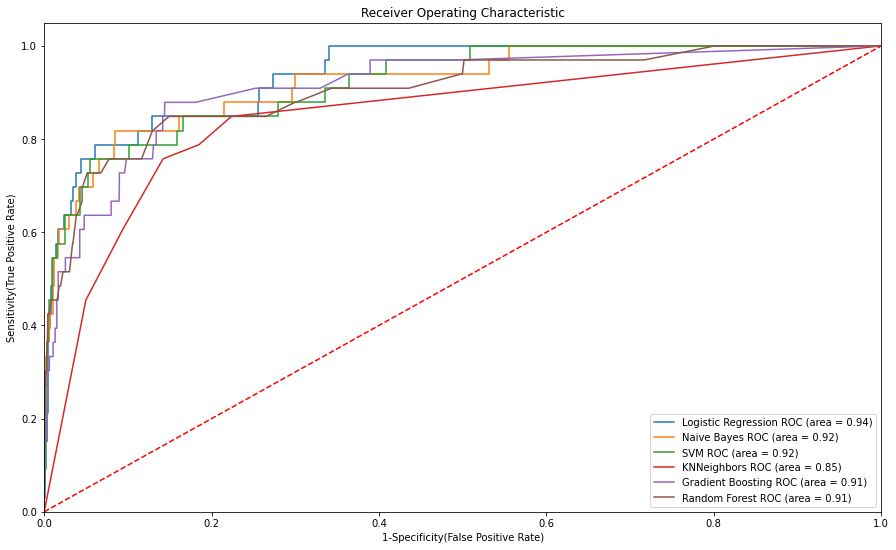

In [13]:
roc = ROC_overlap(predictions)

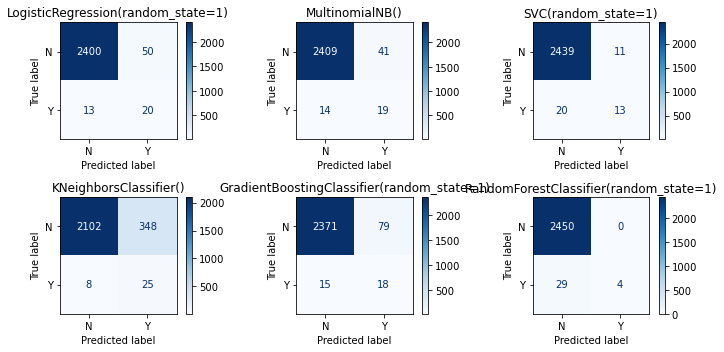

In [14]:
plotConfusion(fitted_models)

     score                model
0  93.7947  Logistic Regression
1  92.2263          Naive Bayes
2  91.9963                  SVM
3  84.9889          KNNeighbors
4  91.2894    Gradient Boosting
5  90.5294        Random Forest


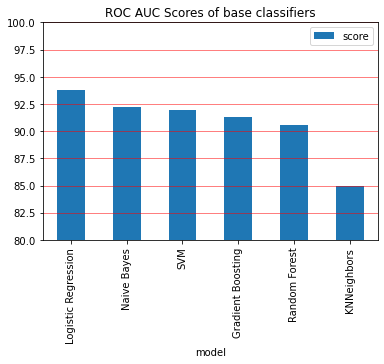

In [15]:
print(df_untuned)
display_scores(df_untuned)

### Tune Hyperparameters

### Logistic Regression model

In [16]:
# Logistic Regression Grid
# not included such as 'dual', 'tol', and 'fit_intercept' unnecessary for this project

LG_grid = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(random_state=1),     
    'grid' : {
                'm__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
                'm__penalty': ['l2', 'l2', 'elasticnet', 'none'],
                'm__class_weight' : ['balanced', 'None'],
                'm__C': [0.1, 1, 10],
                'm__max_iter': [100, 4000, 8000],
                'm__multi_class' : ['auto', 'ovr', 'multinomial'],
                'm__random_state': [1]
              }                                    
}
]

In [17]:
predictions, df, best_params, fitted_models = fit_models(LG_grid)
print(best_params)
print(df)

[{'m__C': 1, 'm__class_weight': 'balanced', 'm__max_iter': 100, 'm__multi_class': 'auto', 'm__penalty': 'l2', 'm__random_state': 1, 'm__solver': 'liblinear'}]
     score                model
0  93.8973  Logistic Regression


### Tune the Naive Bayes model

In [18]:
# Create grid for naive bayes

NB_grid =  [
{   
    'label' : 'Naive Bayes',
    'model' : MultinomialNB(),
    'grid' : {
                'm__alpha' : [0, 1.0],
                'm__fit_prior' : ['True','False']
             }
}
]

In [19]:
predictions, df, best_params, fitted_models = fit_models(NB_grid)
print(best_params)
print(df)

[{'m__alpha': 1.0, 'm__fit_prior': 'True'}]
     score        model
0  92.2263  Naive Bayes


### Tune SVM model

In [20]:
# SVM Grid

SVM_grid = [
    
{   'label' : 'SVM',
    'model' : svm.SVC(random_state=1),
    'grid' : {
                'm__gamma': [1, 0.1, 0.01],
                'm__degree': [1,2,3],
                'm__class_weight':['balanced','None'],
                'm__decision_function_shape':['ovr','ovo'],
                'm__random_state' : [1]
             }
}
]

In [21]:
predictions, df, best_params, fitted_models = fit_models(SVM_grid)
print(best_params)
print(df)

[{'m__class_weight': 'balanced', 'm__decision_function_shape': 'ovr', 'm__degree': 1, 'm__gamma': 1, 'm__random_state': 1}]
     score model
0  92.2325   SVM


### Tune KNN model

In [22]:
KNN_grid =  [
    
{   'label' : 'KNNeighbors',     
    'model' : KNeighborsClassifier(),
    'grid' : {
                'm__n_neighbors': (1,10, 1),
                'm__leaf_size': (2,40,1),
                'm__p': (1,2),
                'm__weights': ('uniform', 'distance'),
                'm__metric': ('minkowski', 'chebyshev'),
             }
}
]

In [23]:
predictions, df, best_params, fitted_models = fit_models(KNN_grid)
print(best_params)
print(df)

[{'m__leaf_size': 2, 'm__metric': 'minkowski', 'm__n_neighbors': 10, 'm__p': 2, 'm__weights': 'distance'}]
     score        model
0  86.5523  KNNeighbors


   ### Tune Gradient Boost

In [24]:
GBA_grid = [

{   'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(random_state=1),
    'grid' : {
                'm__n_estimators': [20,30,40,50,60,70,80],
                'm__random_state' : [1]
             }
}
]

In [25]:
predictions, df, best_params, fitted_models = fit_models(GBA_grid)
print(best_params)
print(df)

[{'m__n_estimators': 60, 'm__random_state': 1}]
     score              model
0  90.9555  Gradient Boosting


### Tune Random Forest Classifier

In [26]:
RFC_grid = [

{   'label' : 'Random Forest',   
     'model' : RandomForestClassifier(random_state=1),
    'grid' : {
                'm__n_estimators': [2500, 5000],
                'm__max_features' : ['auto', 'sqrt', 'log2'],
                'm__max_features' : ['sqrt'],
                'm__random_state' : [1]
             }
}
]

In [27]:
predictions, df, best_params, fitted_models = fit_models(RFC_grid)
print(best_params)
print(df)

[{'m__max_features': 'sqrt', 'm__n_estimators': 5000, 'm__random_state': 1}]
     score          model
0  91.7712  Random Forest


##  Build tuned models

In [28]:
L_grid = {
    'm__solver': ['liblinear'],
    'm__class_weight': ['balanced'],
    'm__max_iter': [100],
    'm__multi_class' : ['auto'],
    'm__random_state': [1],
    'm__C': [1],
    'm__penalty': ['l2'],
}
N_grid = {
    'm__alpha': [1.0], 
    'm__fit_prior': ['True']
}
SV_grid = {
    'm__gamma': [1],
    'm__degree': [1],
    'm__class_weight': ['balanced'],
    'm__random_state': [1],
    'm__decision_function_shape': ['ovr']
}
KN_grid = {
    'm__leaf_size': [2],
    'm__metric': ['minkowski'], 
    'm__n_neighbors': [10], 
    'm__p': [2], 
    'm__weights': ['distance']
}
GB_grid = {   
    'm__n_estimators': [80], 
    'm__random_state': [1]
}, 
RF_grid = { 
    'm__max_features': ['sqrt'],
    'm__n_estimators': [5000],
    'm__random_state': [1]

}

### Create tuned models

In [29]:
    # Models after hyperparameters tuned
models_tuned = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
    'grid' : L_grid
},
{
    'label' : 'Naive Bayes',
    'model' : MultinomialNB(),
    'grid'  : N_grid
},
{
    'label' : 'SVM',
    'model' : svm.SVC(),
    'grid'  : SV_grid
},
{   'label' : 'KNNeighbors',     
    'model' : KNeighborsClassifier(),
    'grid'  : KN_grid
},
{   'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
    'grid' : GB_grid
}, 
{   'label' : 'Random Forest',   
     'model' : RandomForestClassifier(),
    'grid' : RF_grid
}
]

In [30]:
predictions, df_tuned, best_params, fitted_models  = fit_models(models_tuned)
df_tuned

,score,model
0,93.8973,Logistic Regression
1,92.2263,Naive Bayes
2,92.2325,SVM
3,86.5523,KNNeighbors
4,91.1379,Gradient Boosting
5,91.7712,Random Forest


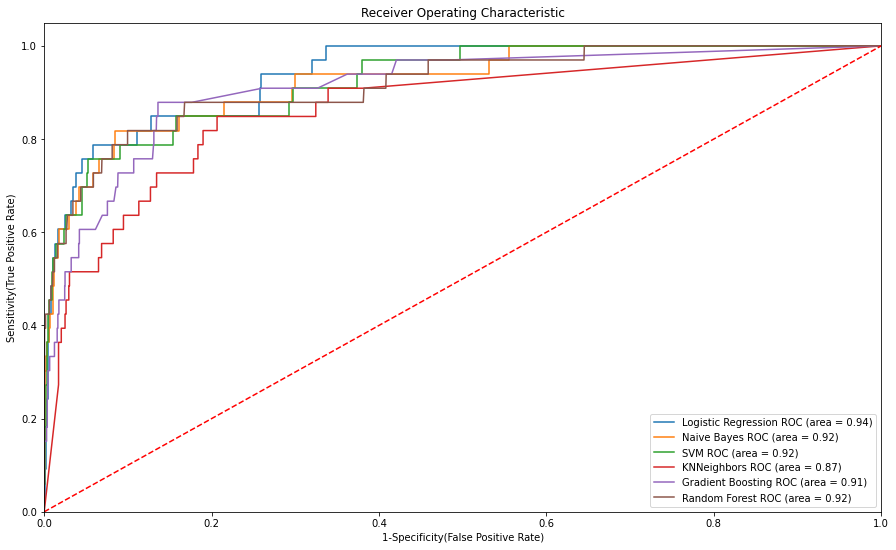

In [31]:
roc = ROC_overlap(predictions)

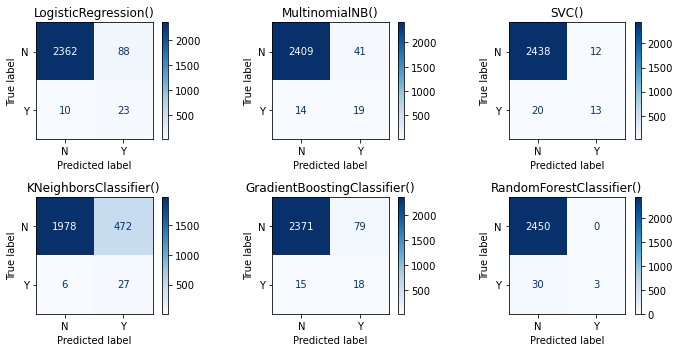

In [32]:
plotConfusion(fitted_models)

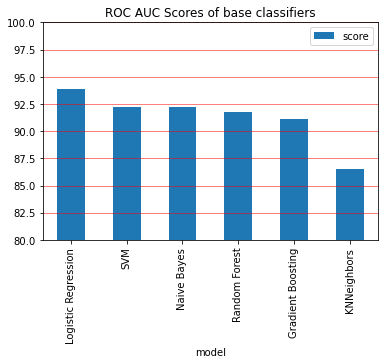

In [33]:
display_scores(df_tuned)

## Results

### Display summary of scores

In [34]:
df_tuned['untuned score'] = ''
df_final = df_tuned.merge(df_untuned, how = 'left', on='model')
df_final = df_tuned.merge(df_untuned, how = 'left', on='model')
df_final = df_final.drop(['untuned score'], axis=1).rename(columns = {'score_y': 'untuned score',
                                                                       'score_x':'tuned score'})
df_final

,tuned score,model,untuned score
0,93.8973,Logistic Regression,93.7947
1,92.2263,Naive Bayes,92.2263
2,92.2325,SVM,91.9963
3,86.5523,KNNeighbors,84.9889
4,91.1379,Gradient Boosting,91.2894
5,91.7712,Random Forest,90.5294


### Display bar plot of scores

<Figure size 2160x360 with 0 Axes>

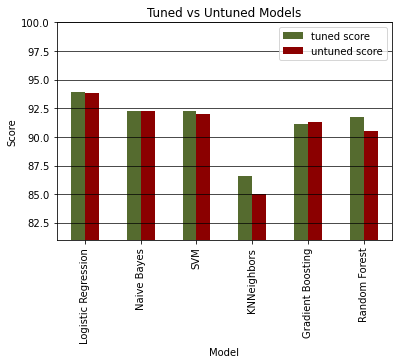

In [35]:
plt.figure(figsize=(30,5))

df_final.plot.bar(x="model", y=["tuned score", "untuned score"],color = ['darkolivegreen', 'darkred'])
plt.ylim([81, 100])
plt.xticks(rotation=90)
plt.grid(color='black', linewidth=1, axis='y', alpha=0.7)
plt.title("Tuned vs Untuned Models")
plt.xlabel("Model")
plt.ylabel("Score")
plt.show()

### Plot the difference between the scores after tuning

<Figure size 2160x360 with 0 Axes>

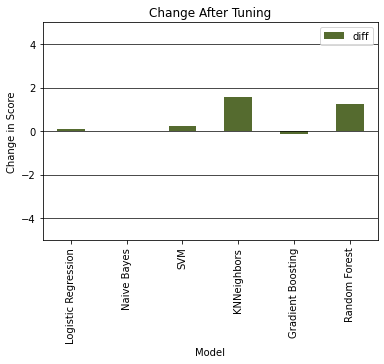

In [36]:

df_tuned['diff']=df_final['tuned score'] - df_final['untuned score']
import matplotlib.pyplot as plt


plt.figure(figsize=(30,5))

df_tuned.plot.bar(x="model", y="diff",color = 'darkolivegreen')
plt.ylim([-5, 5])
plt.xticks(rotation=90)
plt.grid(color='black', linewidth=1, axis='y', alpha=0.7)
plt.title("Change After Tuning")
plt.xlabel("Model")
plt.ylabel("Change in Score")
plt.show()

## Run Models with 'gout' term included.
Previous models were trained and tested after removing the word 'gout' from the corpus.  In order to compare accuracies of the model to ER physician predicted results, the corpus need to be run untampered for comparison.  The models below provide accuracies of the models based on the same corpus/data as the ER physicians had access to.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    wdf['corpus'],                                     
    wdf.target,                                       
    test_size=0.30,                                   
    stratify=wdf.target,                                # Stratify the imbalanced target
    random_state=1,                                    # Constant seed for reproducibility
    shuffle=True                                       # Set for the 'statify' parameter
)
    # Vectoring the corpus from string to int, the TFidf method will weight the keywords
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)
labelencoder=LabelEncoder()                     # Simple direct encoding from string to int
E_y_test = labelencoder.fit_transform(y_test)

In [39]:
predictions, df_tuned, best_params, fitted_models  = fit_models(models_tuned)
df_tuned

,score,model
0,99.6895,Logistic Regression
1,98.5739,Naive Bayes
2,99.5931,SVM
3,97.29,KNNeighbors
4,98.0303,Gradient Boosting
5,99.6957,Random Forest


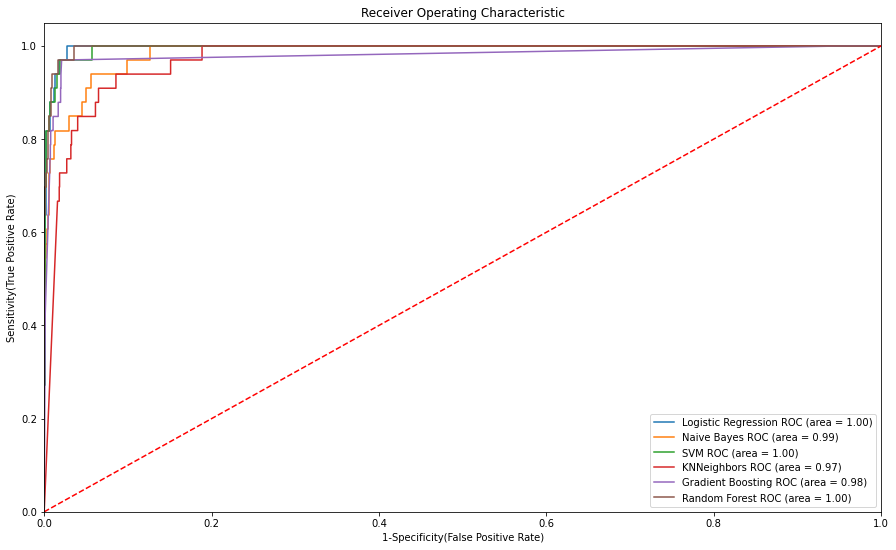

In [40]:
roc = ROC_overlap(predictions)

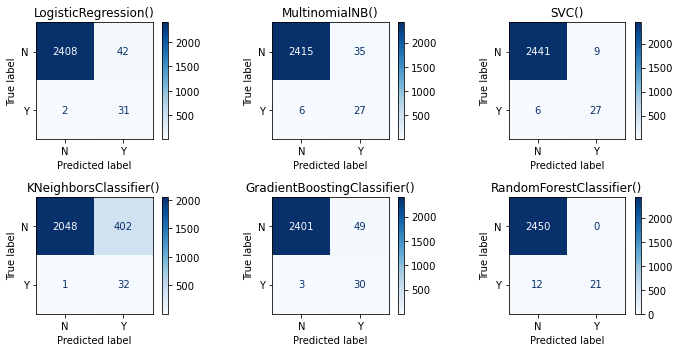

In [41]:
plotConfusion(fitted_models)

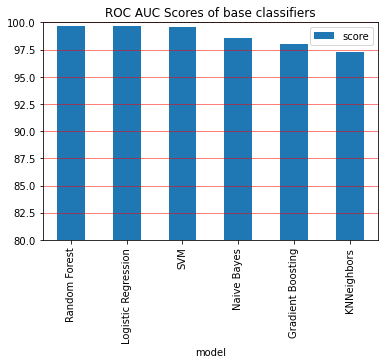

In [42]:
display_scores(df_tuned)